In [12]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/accepted-2007-to-2018q4/accepted_2007_to_2018Q4.csv


Fitting 3 folds for each of 10 candidates, totalling 30 fits
✅ Best Parameters Found: {'subsample': 0.6, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.2, 'colsample_bytree': 1.0}
✅ Best Threshold Found: 0.41
✅ Optimized Model Accuracy: 0.4962
✅ Optimized ROC AUC Score: 0.6455
✅ Precision: 0.1691
✅ Recall: 0.8407
✅ F1-Score: 0.2815
✅ Confusion Matrix:
 [[167884 204914]
 [  7904  41698]]
✅ Expected Loss Calculation Results:
         PD      EAD  LGD  Expected_Loss
0  0.655294   3600.0  0.5    1179.528558
1  0.876515  24700.0  0.5   10824.963576
2  0.784340  20000.0  0.5    7843.402028
3  0.711457  35000.0  0.5   12450.492531
4  0.185750  10400.0  0.5     965.898877
✅ Total Expected Loss: $1,555,119,139.77
📊 Expected Loss Statistics:
count    422400.000000
mean       3681.626751
std        3003.554518
min           3.240355
25%        1398.384635
50%        2874.217480
75%        5160.682172
max       19650.875330
Name: Expected_Loss, dtype: float64


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


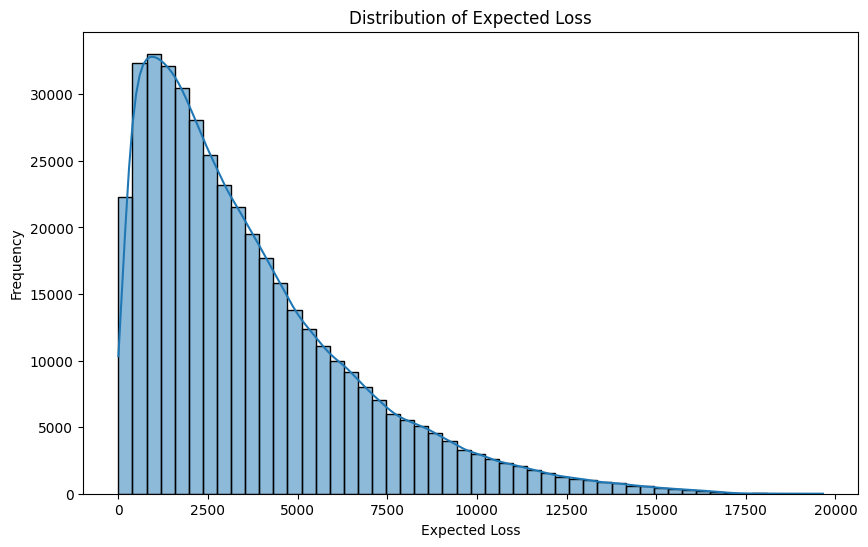

✅ Expected Loss results saved to '/kaggle/working/expected_loss_results.csv'.


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# ✅ Load the dataset (Kaggle Zset path)
accepted_loans_file = "/kaggle/input/accepted-2007-to-2018q4/accepted_2007_to_2018Q4.csv"
df = pd.read_csv(accepted_loans_file, low_memory=False)

# ✅ Selecting relevant columns
columns_to_keep = ["loan_amnt", "term", "int_rate", "installment", "grade", "sub_grade", 
                   "emp_length", "home_ownership", "annual_inc", "dti", "revol_util", "loan_status"]
df = df[columns_to_keep]

# ✅ Handling missing values
df = df.dropna()

# ✅ Convert categorical variables
df["term"] = df["term"].str.extract("(\d+)").astype(int)
df["emp_length"] = df["emp_length"].str.extract("(\d+)").astype(float)
df["home_ownership"] = df["home_ownership"].astype("category").cat.codes
df["grade"] = df["grade"].astype("category").cat.codes
df["sub_grade"] = df["sub_grade"].astype("category").cat.codes

# ✅ Convert interest rate and revolving utilization to numeric
df["int_rate"] = pd.to_numeric(df["int_rate"].astype(str).str.replace("%", ""), errors='coerce')
df["revol_util"] = pd.to_numeric(df["revol_util"].astype(str).str.replace("%", ""), errors='coerce')

# ✅ Feature Engineering: Adding new features
df["credit_utilization_ratio"] = df["revol_util"] / df["annual_inc"]
df["income_to_installment_ratio"] = df["annual_inc"] / df["installment"]

# ✅ Define target variable (loan default)
df["loan_status"] = df["loan_status"].apply(lambda x: 1 if x in ["Charged Off", "Default"] else 0)

# ✅ Split data into training and testing sets
X = df.drop(columns=["loan_status"])
y = df["loan_status"]

# ✅ Handle infinite values and NaNs before scaling
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(X.mean(), inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ Standardize Features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ✅ Apply SMOTE for class balancing
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# ✅ Hyperparameter tuning using RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

random_search = RandomizedSearchCV(
    XGBClassifier(scale_pos_weight=5, use_label_encoder=False, eval_metric="logloss", random_state=42),
    param_distributions=param_grid,
    n_iter=10,
    scoring='roc_auc',
    cv=3,
    verbose=1,
    n_jobs=-1
)

random_search.fit(X_train_resampled, y_train_resampled)

# ✅ Best model from hyperparameter tuning
best_model = random_search.best_estimator_
print(f"✅ Best Parameters Found: {random_search.best_params_}")

# ✅ Make probability predictions
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# ✅ Optimize classification threshold using Precision-Recall Curve
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)
best_threshold_index = np.argmax(precisions * recalls)
best_threshold = thresholds[best_threshold_index]

# ✅ Apply best threshold
y_pred = (y_pred_proba >= best_threshold).astype(int)

print(f"✅ Best Threshold Found: {best_threshold:.2f}")

# ✅ Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"✅ Optimized Model Accuracy: {accuracy:.4f}")
print(f"✅ Optimized ROC AUC Score: {roc_auc:.4f}")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall: {recall:.4f}")
print(f"✅ F1-Score: {f1:.4f}")
print("✅ Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# ✅ Expected Loss Calculation
LGD = 0.5  # Assume Loss Given Default = 50%

# ✅ Convert X_test back to a DataFrame
df_test = pd.DataFrame(X_test, columns=X.columns)
df_test["PD"] = y_pred_proba  # Predicted probabilities of default

# ✅ Fix loan amount indexing issue
df_reset = df.reset_index(drop=True)  # Reset index for alignment
df_test["EAD"] = df_reset.loc[df_test.index, "loan_amnt"].values  # Correct mapping

df_test["LGD"] = LGD  
df_test["Expected_Loss"] = df_test["PD"] * df_test["EAD"] * df_test["LGD"]  

# ✅ Display Expected Loss results
print("✅ Expected Loss Calculation Results:")
print(df_test[["PD", "EAD", "LGD", "Expected_Loss"]].head())

# ✅ Total Expected Loss
total_expected_loss = df_test["Expected_Loss"].sum()
print(f"✅ Total Expected Loss: ${total_expected_loss:,.2f}")

# ✅ Expected Loss statistics
print("📊 Expected Loss Statistics:")
print(df_test["Expected_Loss"].describe())

# ✅ Plot distribution of Expected Loss
plt.figure(figsize=(10, 6))
sns.histplot(df_test["Expected_Loss"], bins=50, kde=True)
plt.title("Distribution of Expected Loss")
plt.xlabel("Expected Loss")
plt.ylabel("Frequency")
plt.show()

# ✅ Save results to CSV
df_test.to_csv("/kaggle/working/expected_loss_results.csv", index=False)
print("✅ Expected Loss results saved to '/kaggle/working/expected_loss_results.csv'.")
